## Pytorch Community Voices Demo - MindsDB
### 2021.09.01

Author: Natasha Seelam, PhD (natasha@mindsdb.com)

In the following notebook, we'll show you how you can make your own custom encoder, and pipeline, using lightwood under the hood. The model we've chosen is a **Masked Language Model**, and specifically, we're going to treat it as if it were a classifier.

**Please note, the typical classification strategy is to place a linear layer after the transformer and fine tune (this MindsDB's default). This example just demonstrates that we can still build our own custom encoder to leverage novel pytorch models with diverse loss functions and criteria.**

Please feel free to email us, or join our community slack if you have any questions you'd like to discuss!

In [1]:
import pandas as pd
import numpy as np

# Machine learning
import torch
import lightwood as lw
from lightwood import ProblemDefinition, JsonAI, json_ai_from_problem, code_from_json_ai, predictor_from_code

import os
import time

In [2]:
# Lightwood version > 1.0.0 supports J{ai}-SON : )
print("Version", lw.__version__)

Version 1.1.0


In [3]:
# Setup torch seed for reproducibility
torch.manual_seed(1234)

## 1) Load the dataset

We'll use a tripadvisor hotel review dataset (found on [kaggle](https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews)).
The goal of this dataset is to be able to predict the rating (1-5 stars, with 1 being the lowest and 5 being the highest) of the hotel, given an arbitary review.

In [4]:
%ls datasets/

tripadvisor/


In [5]:
data_dir = "datasets/"
dataset = "tripadvisor"
filename = os.path.join(data_dir, dataset, "data.csv")


# Load the data, and scramble the order. The way the data has been 
data = pd.read_csv(filename).sample(frac=1, random_state=42)

data.head()

,Review,Rating
10726,not recommend hotel did reviewers actually sta...,1
14919,"barcelona rocks, stayed hotel jazz girlfriend ...",4
19098,ok hotel good location stayed night way beijin...,3
2450,great service nice pool ok beach lovely ground...,4
960,surprising treat spent weekend july 15/16 2006...,5


We can see the polarity between a 5-star and 1-star rating. Positive words are more associated to good reviews versus one-star labels.

In [6]:
# Rating examples
print("\033[1m" + "Five star (Label=5) Review:\n" + "\033[0m")
print(data[data["Rating"] == 5]["Review"].iloc[0])

print("\033[1m" + "\n\nOne star (Label=1) Review: \n" + "\033[0m")
print(data[data["Rating"] == 1]["Review"].iloc[0])


Five star (Label=5) Review:

surprising treat spent weekend july 15/16 2006 cartwright hotel based purely recommendations read site, actually expecting like small older european hotel, cartwright amazing, small elegant pleasant staff knowlegable city, room small nicely appointed queen bed linens quality, no airconditioning temperatures sf rarely warrant open windows fresh air night 4th floor, wine hour afternoon gave opportunity meet guests share days adventures breakfast buffet adequate, walk half block powell st cable car usually crowded stop, sf taxi cabs clean reasonably priced usually came built tour guide unlike cities english optional business, cartwright definitely hotel choice return san francisco,  


One star (Label=1) Review: 

not recommend hotel did reviewers actually stay hotel did, good thing hotel location really close leidseplein, shared facilities filthy got, did not look toilet floor cleaned month, facilities not cleaned 3 days got, disgusting, staff rude complained

The ratings distribution is not equivalent across all labels; while we will use accuracy, we encourage considering other metrics to predict on such as precision, recall, and accuracy. For simplicity, we merely consider the accuracy.

Text(0.5, 1.0, 'Ratings distribution')

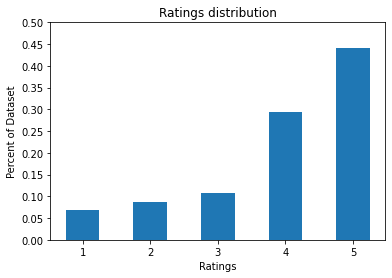

In [7]:
# An example of the distribution of the model 

import matplotlib.pyplot as plt

# Distribution of the ratings
fig, ax = plt.subplots(1,1, figsize=(6,4))

hist, bins = np.histogram(data["Rating"], bins=np.arange(0.5, 6.5, 1))

ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=0.5)
ax.set_xticks([i+0.5 for i in range(5)])
ax.set_xticklabels([str(i+1) for i in range(5)])
ax.set_yticks(np.arange(0, 0.55, 0.05))

ax.set_xlabel("Ratings")
ax.set_ylabel("Percent of Dataset")
ax.set_title("Ratings distribution")

As indicated before, we will split our data into a training/testing branch.

In [8]:
# We'll split our training/testing fraction manually

ptrain = 0.8
Ntrain = int(data.shape[0] * ptrain)
Ntest = int(data.shape[0] - Ntrain)

train = data.iloc[:Ntrain, :]
test = data.iloc[Ntrain:, :]

## 2) Building your own custom encoder

**NOTE**: *When I tested this encoder, I found I needed at least 8GB of VRAM and a GPU.*

For our custom encoder, we will use a **masked language model** (MLM). To explain how an MLM works, imagine a sentence like this:

"This hotel is amazing! I loved my stay here, the bed was comfy and everything was perfect!"

We can convert this into a classification problem using MLM as such:

"Label is [MASK]. This hotel is amazing! I loved my stay here, the bed was comfy and everything was perfect!"

The goal would be to predict whether the hidden token is a positive or negative sentiment. To do this, we will construct "placeholder" tokens that represent the hidden label. The model then computes losses to try to predict what hidden token should replace the underlying label. The ground-truth label will be one of the placeholders we setup.

For convenience, we have provided 2 different scripts, `custom_encoder.py` and `mlm_helpers.py`. The `custom_encoder` script provides an example of how to build an MLM for classification, and `mlm_helpers`, as the name suggests, provides a few functions to help construct labels, new vocabulary, and train a model. 

We will show how to integrate this as a separate branch in the lightwood repo, and train with your own encoder of choice.

### 2a) Making the custom encoder files 

The goal of the encoder is to learn a representation. Some encoders can be trained or "tuned" to generate a representation related to a particular label to ensure the representations contain useful information. In this simple example, we will tune the encoder with the target data.

In this case, a representation is a feature vector that translates the "data" space into a format that is usable by a model. The term "feature vector", "representation", and "embedding" will be used interchangeably hence forth.

![This is the caption\label{mylabel}](images/fig1.png)
*Figure 1: A representation will take an arbitrary sentence, like this hotel review, and convert it into some vector that a model can use. How the vector is constructed depends on the modeling of the language.*
<br>

In the following example in ```custom_encoder.py``` we consider the ```MLMEncoder``` class. All base encoders require the following steps:

(1) an ```__init__``` call used to instantitate the details of the encoder. The only required component of this call is to ensure that the encoder knows whether you are tuning the embeddings to the target or not.  

(2) A ```prepare``` call; This sets up the preliminary ground work of tokenizing and training the encoder to the representation of interest. You can think of this as the ***feature extraction step***

(3) An ```encode``` command; this creates a representation/embedding that will be provided downstream to the mixer or predictive model of the piepline .

(4) A ```decode``` step; This steps translated the featurized form back into the original space. For text, we implemented an Exception, as decoding will be tricky (as an aside -one possible option is to decode back into the tokenized space for language generation!)

(5) A ```to``` step; this step enables you to set the model to a different device (CPU/CUDA)

For specific highlights of the custom encoder, see the script available. As a high level overview:

1) The prepare step calls the ```DistilBertForMaskedLanguageModeling``` model and ```DistilBertTokenizerFast``` for the model and tokenizer respectively  

2) It prepares a priming sentence with a "[MASK]" to be predicted, with the help of ```mlm_helpers``` functions.  

3) For each label, it creates a new token "[Ci]" where $i$ represents the label number and resizes it to the tokenizer and the model embedding dimensionality. The goal of the model is to predict which token must appear under the Mask.

4) It trains the MLM to predict the mask from the underlying label for 1 epoch (default)  

5) The encoder creates an embedding by predicting what the underlying mask token is, replacing it in the model input, and then calculating the last hidden-state of the base DistilBert model and presenting the "[CLS]" token.

For simplicity, we've made these encoders in a custom branch of lightwood. You can access it as:

```git clone -b custom_mlm git@github.com:mindsdb/lightwood.git``` 

Alternatively, you can place the two python files in your own branch of lightwood and edit the ``__init__`` files accordingly, as we'll describe below:

You can see within ```lightwood/encoder/text``` the new encoder ```custom_encoders.py``` script.

Subsequently, for the helpers file, it is in ```lightwood/encoders/text/helpers```.

Now, we need to provide references for lightwood to access these encoders. Change the ```__init__.py``` file in ```lightwood/encoder/text/``` and ```lightwood/encoder/``` to enable lightwood to "see" your encoders.

![This is the caption\label{mylabel}](images/fig2.png)
<br>


Lastly, make sure to add the `unit_classifier` script to `lightwood/model/` and change the `__init__.py` file there too.

In the spirit of lightwood, we have the following:<br>
(1) Data pre-processing <br>
(2) Feature engineering *via* Encoders <br>
(3) Model building *via* Models<br>.

Under the hood, we'll see that lightwood will recognize the types of each data column (Review - rich text, Rating - categorical). What we want to customize is the feature engineering and model building.

Typically, the feature engineering for text would be to create this fixed length embedding. If we had other columns of data, we could concatenate this vector with the other data outputs. However, we have only one output, so we'll do the following:

(A) Train an encoder to predict the masked token. This will be the transformer (neural network) that is trained
(B) Use a model that inherits the encoder, takes the logits of the output and soft-maxes it. We call this the `UnitClassifier` model.

## 3) Testing your new encoder out!

Let's now go ahead and use the J{ai}SON language to run our custom encoder.

First, we need to define the problem-definition. All we need to specify is the goal of what we're trying to predict. In this case, the output will be `Rating`.

Once we specify a problem definition, we can feed into J{ai}SON using `json_ai_from_problem`. We need to specify our input dataframe (`data`) and the problem definition before.

In [9]:
# Create the problem definition

problem_definition = {'target': 'Rating'}

# Generate the j{ai}son syntax
JsonAI = json_ai_from_problem(data, problem_definition)

INFO:lightwood-3276:Analyzing a sample of 10044
INFO:lightwood-3276:from a total population of 20491, this is equivalent to 49.0% of your data.
INFO:lightwood-3276:Using 15 processes to deduct types.
INFO:lightwood-3276:Infering type for: Rating
INFO:lightwood-3276:Infering type for: Review
INFO:lightwood-3276:Column Rating has data type categorical
INFO:lightwood-3276:Doing text detection for column: Review
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natasha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:lightwood-3276:Starting statistical analysis
INFO:lightwood-3276:Finished statistical analysis


In [10]:
json_filename = "sample_customtext.json"
with open(json_filename, "w") as fp:
   fp.write(JsonAI.to_json())

Under the hood, what we see is the following:

(1) Lightwood takes a sample of your data to make some inferences on type (ex it sees 'Rating' as Categorical and 'Review' as text. <br>
(2) It performs a statistical analysis around the distribution (ex: a histogram/bar chart of numerical quantities). <br>
(3) Provides a JsonAI object that holds descriptors of the framework. <br>

We want to modify the defaults so that we are using our own `MLMEncoder`. You may also want to feed in non-default keywords under the `"args": {}` component.

Note, we will use the `UnitClassifier` model, a variant of our `Unit` model. Normally, for datasets with multiple columns, encoders featurize each column of data. We then can concatenate all those features for a vector that represents the multiple columns; lightwood then allows you to test multiple predictor algorithms to see which may work optimally (usually `Neural` for a neural network and `LightGBM` for the tree-based method. 

In this case, we only have 1 column of data, and 1 target. Training another model on top of the transformer is overkill, so in the interest of time, we omit all other models to explicitly inherit the encoder's model. This variant in particular clamps the output so it only returns a guess. In our internal modules, we keep an "unknown" class to help our models generalize to unseen distributions.

Once the JSON input has been generated, we'll edit the feature's module, specifically for the 'Review' column as follows:
![This is the caption\label{mylabel}](images/fig3.png)
<br>

In general, you can manually modify any feature you want OR specify *a priori* if you're comfortable with the JSON format. This applies to features, or models, which are the predictors that actually generate the output. You can also edit models by specifying them under the tab above

After you edit your JSON file (you can alternatively load "sample_customtext_modified.json"), go ahead and re-load it with the following command:

In [11]:
# Load the json AI
json_filename = "sample_customtext_modified.json"
with open(json_filename, "r") as fp:
   modified_json = JsonAI.from_json(fp.read())


In [12]:
# Import the two new calls
modified_json.imports = ['from lightwood.model import UnitClassifier', 'from lightwood.encoder import MLMEncoder']

Once you have this, you can convert the JsonAI into template python code to construct a predictor! This auto-generates all you need to run the framework end-to-end

In [13]:
# Generate some code
code = code_from_json_ai(modified_json)
print(code)


from lightwood.model import UnitClassifier
from lightwood.encoder import MLMEncoder
from lightwood.model import Neural
from lightwood.model import LightGBM
from lightwood.model import LightGBMArray
from lightwood.model import SkTime
from lightwood.model import Unit
from lightwood.model import Regression
from lightwood.ensemble import BestOf
from lightwood.data import cleaner
from lightwood.data import transform_timeseries, timeseries_analyzer
from lightwood.data import splitter
from lightwood.analysis import model_analyzer, explain
from sklearn.metrics import r2_score, balanced_accuracy_score, accuracy_score
import pandas as pd
from lightwood.helpers.seed import seed
from lightwood.helpers.log import log
import lightwood
from lightwood.api import *
from lightwood.model import BaseModel
from lightwood.encoder import BaseEncoder, __ts_encoders__
from lightwood.encoder import Array, Binary, Categorical, Date, Datetime, Float, Image, Integer, Quantity, Rich_Text, Short_Text, Tags
from lig

From above, we see this is what a start-to-finish script would look like. We auto-generate all imports, necessary keywords, and details required to train your custom models. From here, all we need to do is make a predictor "object" and then train it!

Let's make that predictor object and get started!

In [14]:
# Turn the code above into a predictor object
predictor = predictor_from_code(code)

# Run the generated code on the dataset!
predictor.learn(data)

INFO:lightwood-3276:Starting statistical analysis
INFO:lightwood-3276:Finished statistical analysis
INFO:lightwood-3276:distilbert-base-uncased MLM text encoder
INFO:lightwood-3276:Embedding mode off. Logits are output of encode()
INFO:lightwood-3276:Cleaning the data
INFO:lightwood-3276:Splitting the data into 30 folds
INFO:lightwood-3276:Preparing the encoders
INFO:lightwood-3276:Encoder preping dict length of: 1
INFO:lightwood-3276:Done running for: Rating
INFO:lightwood-3276:Training model.
INFO:lightwood-3276:Preparing the training data
INFO:lightwood-3276:Training the model
/home/natasha/Documents/lightwood/lightwood/encoder/text/helpers/mlm_helpers.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
INFO:lightwood-3276:distilbert-base-uncased MLM text en

From the log file, you should see that we call the `distilbert-base-uncased MLM text encoder`. We also see that we deploy 2 encoders - one for Rating which represents it as a one-hot-encoded vector and one for the Review, which uses the MLM model. You'll see the term 'Training model' twice - this automatically flags for each encoder you deploy, whether it is rule based or trained.

You'll see some notes from the MLM encoder - the output of the encode flag will be the logits of the class, or tokens we represented. The unit mixer will directly inherit that and make for an easy output.

Let's now put this to the test - let's predict on our test set. The output will be a pandas DataFrame.

In [15]:
result = predictor.predict(test)

INFO:lightwood-3276:Cleaning the data


We can see the output has the ground-truth values, the predictions from Lightwood, and the confidence based on the logits. Higher confidences suggest stronger conviction in the predictors. Given the model has a MASSIVE vocabulary, and the very shallow training we did, it's unsurprising our confidences are generally low:

In [16]:
# Observe a few instances
result.head()

,truth,prediction,confidence
0,3,2,0.29
1,1,2,0.19
2,4,2,0.19
3,5,5,0.39
4,5,5,0.39


Let's see how the distributions of ground-truth matched up with the predicted values:

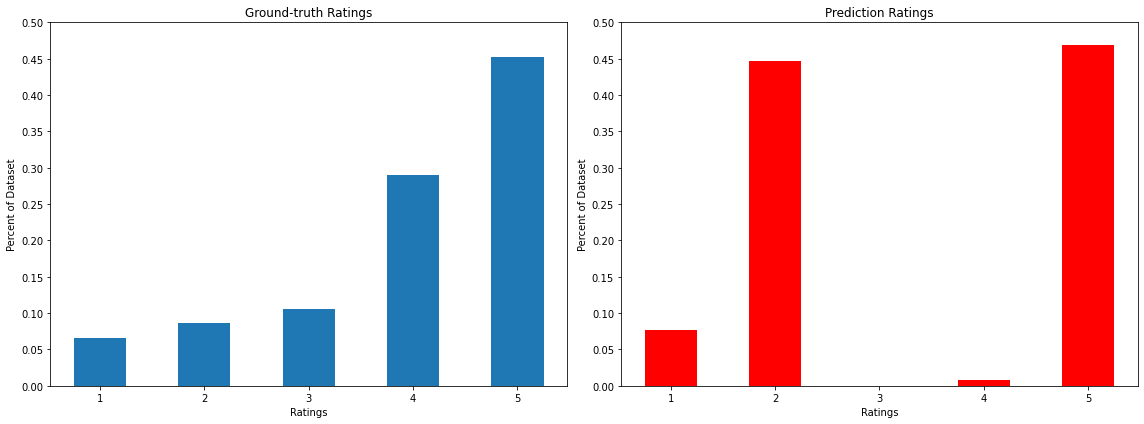

In [17]:
# An example of the distribution of the model 

import matplotlib.pyplot as plt

# Distribution of the ratings
f, ax = plt.subplots(1, 2, figsize=(16,6))

hist, bins = np.histogram(result["truth"].astype(int), bins=np.arange(0.5, 6.5, 1))
hist2, _ = np.histogram(result["prediction"].astype(int), bins=np.arange(0.5, 6.5, 1))

ax[0].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=0.5)
ax[0].set_xticks([i+0.5 for i in range(5)])
ax[0].set_xticklabels([str(i+1) for i in range(5)])
ax[0].set_yticks(np.arange(0, 0.55, 0.05))

ax[0].set_xlabel("Ratings")
ax[0].set_ylabel("Percent of Dataset")
ax[0].set_title("Ground-truth Ratings")


ax[1].bar(bins[:-1], hist2.astype(np.float32) / hist2.sum(), width=0.5, color='r')
ax[1].set_xticks([i+0.5 for i in range(5)])
ax[1].set_xticklabels([str(i+1) for i in range(5)])
ax[1].set_yticks(np.arange(0, 0.55, 0.05))

ax[1].set_xlabel("Ratings")
ax[1].set_ylabel("Percent of Dataset")
ax[1].set_title("Prediction Ratings")
f.tight_layout()

The model seems to allocate high reviews (4s and 5s) and low reviews (1s) together. It is possible that positive sentiment is clear in high reviews, but middling ones (like 2s and 3s) might be hard to differentiate, hence map to 2.